# Day One

## Returns

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf 
from scipy import stats

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from arch import arch_model

In [8]:
ticker = "TSLA"
df = yf.download(ticker, start="2023-01-01", end="2026-01-01")
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2023-01-03,108.099998,118.800003,104.639999,118.470001,231402800
2023-01-04,113.639999,114.589996,107.519997,109.110001,180389000
2023-01-05,110.339996,111.750000,107.160004,110.510002,157986300
2023-01-06,113.059998,114.389999,101.809998,103.000000,220911100
2023-01-09,119.769997,123.519997,117.110001,118.959999,190284000


In [9]:
prices = df["Close"].dropna()
prices.head()

Ticker,TSLA
Date,
2023-01-03,108.099998
2023-01-04,113.639999
2023-01-05,110.339996
2023-01-06,113.059998
2023-01-09,119.769997


In [10]:
log_returns = np.log(prices / prices.shift(1)).dropna()
log_returns.head()

# log_5d = np.log(prices / prices.shift(5)) for a 5 day return

Ticker,TSLA
Date,
2023-01-04,0.049979
2023-01-05,-0.029469
2023-01-06,0.024352
2023-01-09,0.057655
2023-01-10,-0.007711


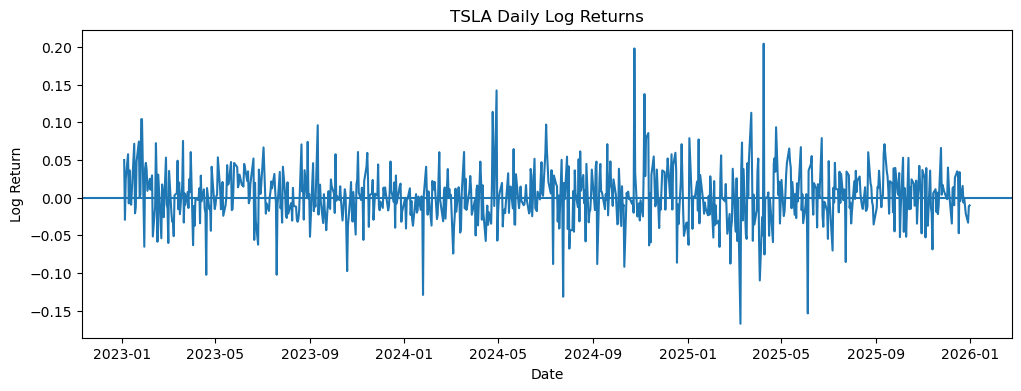

In [11]:
plt.figure(figsize=(12,4))
plt.plot(log_returns)
plt.title(f"{ticker} Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.axhline(0)  # zero line
plt.show()

## Volatility

In [12]:
daily_vol = log_returns.std()
annual_vol = daily_vol * np.sqrt(252)


In [13]:
# Example: 21-day rolling vol (approx 1 month)

rolling_vol = log_returns.rolling(21).std()
rolling_annual_vol = rolling_vol * np.sqrt(252)

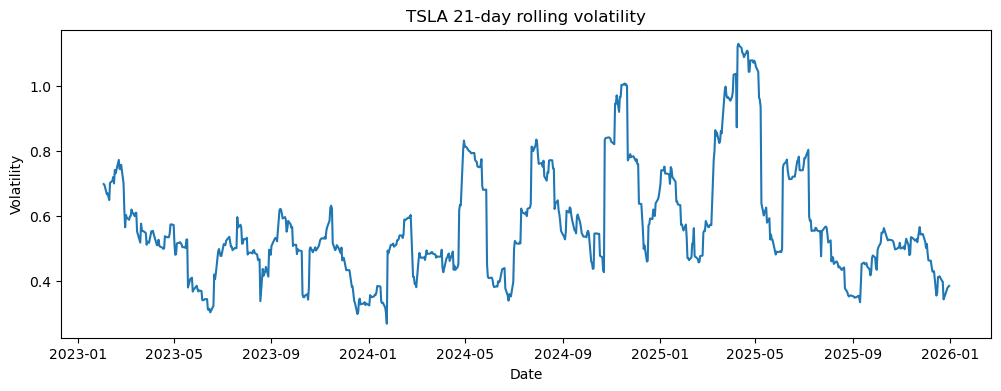

In [14]:
plt.figure(figsize=(12,4))
plt.plot(rolling_annual_vol)
plt.title(f"{ticker} 21-day rolling volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()

# Day Two

## Distribution

In [15]:
# sanity check

print("Rows of prices:", len(prices))
print("Rows of log returns:", len(log_returns))
print("Min/Max daily log return:", log_returns.min(), log_returns.max())

Rows of prices: 752
Rows of log returns: 751
Min/Max daily log return: Ticker
TSLA   -0.167546
dtype: float64 Ticker
TSLA    0.204491
dtype: float64


In [16]:
# compute mean and std

mu = log_returns.mean()
sigma = log_returns.std()

mu, sigma

(Ticker
 TSLA    0.001898
 dtype: float64,
 Ticker
 TSLA    0.037507
 dtype: float64)

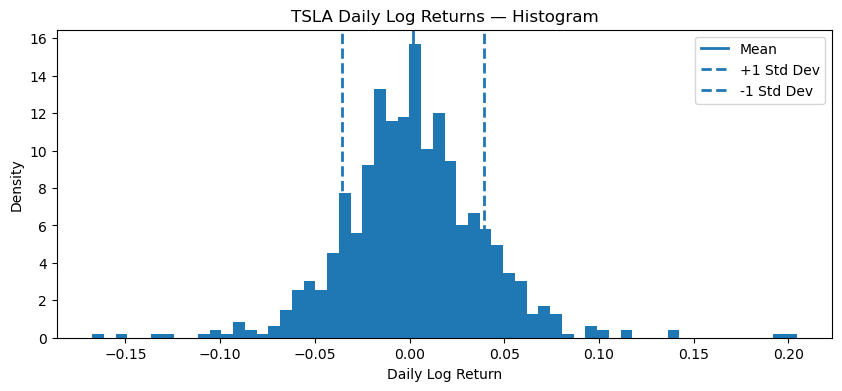

In [17]:
plt.figure(figsize=(10,4))
plt.hist(log_returns, bins=60, density=True)  # density=True makes it comparable across bin choices

plt.axvline(mu.item(), linewidth=2, label="Mean")
plt.axvline((mu + sigma).item(), linewidth=2, linestyle="--", label="+1 Std Dev")
plt.axvline((mu - sigma).item(), linewidth=2, linestyle="--", label="-1 Std Dev")

plt.title(f"{ticker} Daily Log Returns — Histogram")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()


In [18]:
# normality check: skewness + kurtosis

skew = log_returns.skew()
kurt = log_returns.kurt()

skew, kurt

(Ticker
 TSLA    0.232566
 dtype: float64,
 Ticker
 TSLA    3.329323
 dtype: float64)

In [19]:
skew_scipy = stats.skew(log_returns, bias=False)
kurt_scipy = stats.kurtosis(log_returns, fisher=True, bias=False)

skew_scipy, kurt_scipy

(array([0.23256552]), array([3.32932296]))

In [20]:
# Sharpe Ratio

rf = 0.0

sharpe_daily = (mu - rf) / sigma
sharpe_annual = sharpe_daily * np.sqrt(252)

sharpe_daily, sharpe_annual


(Ticker
 TSLA    0.05061
 dtype: float64,
 Ticker
 TSLA    0.803403
 dtype: float64)

This Sharpe hides tail risk because volatility treats gains and losses equally and ignores rare but extreme drawdowns.

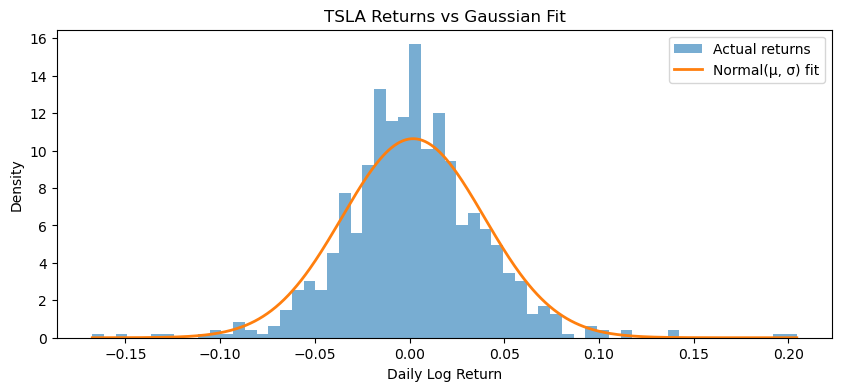

In [21]:
x = np.linspace(log_returns.min(), log_returns.max(), 500)
normal_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)

plt.figure(figsize=(10,4))
plt.hist(log_returns, bins=60, density=True, alpha=0.6, label="Actual returns")
plt.plot(x, normal_pdf, linewidth=2, label="Normal(μ, σ) fit")

plt.title(f"{ticker} Returns vs Gaussian Fit")
plt.xlabel("Daily Log Return")
plt.ylabel("Density")
plt.legend()
plt.show()


# Day Three

## Downside Volatility

In [22]:
# isolate negative days and compute vols

downside_returns = log_returns[log_returns < 0]
overall_vol = log_returns.std().item()
downside_vol = downside_returns.std().item()

overall_vol, downside_vol

(0.03750722857105433, 0.02417471867838017)

In [23]:
# compare clearly

print(f"Overall daily Vol: {overall_vol:.6f}")
print(f"Downside daily Vol: {downside_vol:.6f}")
print(f"Downside/Overall Vol: {downside_vol / overall_vol:.3f}")
print(f"Negative days count: {len(downside_returns)} / {len(log_returns)}")

Overall daily Vol: 0.037507
Downside daily Vol: 0.024175
Downside/Overall Vol: 0.645
Negative days count: 751 / 751


### Sortino Ratio

In [24]:
# compute daily Sortino

rf = 0.0

mean_daily = log_returns.mean().item()
downside_dev = downside_returns.std().item()

sortino_daily = (mean_daily - rf) / downside_dev
sortino_annual = sortino_daily * np.sqrt(252)

sortino_daily, sortino_annual

(0.07852116094396243, 1.246484787082814)

In [25]:
# compute Sharpe again (for comparison)

sharpe_daily = (mean_daily - rf) / overall_vol
sharpe_annual = sharpe_daily * np.sqrt(252)

print(f"Sharpe (daily):   {sharpe_daily:.4f}")
print(f"Sharpe (annual):  {sharpe_annual:.4f}")
print(f"Sortino (daily):  {sortino_daily:.4f}")
print(f"Sortino (annual): {sortino_annual:.4f}")


Sharpe (daily):   0.0506
Sharpe (annual):  0.8034
Sortino (daily):  0.0785
Sortino (annual): 1.2465


### Maximum Drawdown

In [26]:
# cumulative returns (from log returns)
cum_returns = np.exp(log_returns.cumsum())

# rolling peak and drawdown series
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min().item()

max_drawdown


-0.5376568011858518

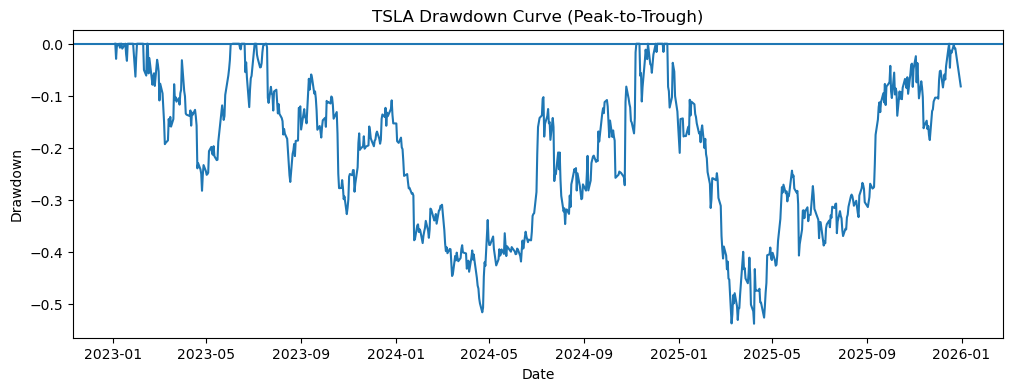

In [27]:
# plot drawdown curve

plt.figure(figsize=(12,4))
plt.plot(drawdown)
plt.title("TSLA Drawdown Curve (Peak-to-Trough)")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.axhline(0)
plt.show()


In [28]:
print(f"Max Drawdown: {max_drawdown:.2%}")

worst_date = drawdown.idxmin()
print("Worst drawdown date:", worst_date.iloc[0].date())
print("Worst drawdown value:", f"{max_drawdown:.2%}")


Max Drawdown: -53.77%
Worst drawdown date: 2025-04-08
Worst drawdown value: -53.77%


# Day Four

## Autocorrelation & Market Memory & GARCH

In [34]:
# lag 1 and lag 5

if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

lag1 = log_returns.autocorr(lag=1)
lag5 = log_returns.autocorr(lag=5)

print(f"Returns autocorr (lag 1): {lag1:.6f}")
print(f"Returns autocorr (lag 5): {lag5:.6f}")

Returns autocorr (lag 1): -0.008628
Returns autocorr (lag 5): -0.003758


In [35]:
# Sweep more lags (to see “memory fingerprint”)

lags = [1, 2, 3, 5, 10, 20]
ac_vals = {lag: log_returns.autocorr(lag=lag) for lag in lags}

pd.Series(ac_vals, name="autocorr").to_frame()

,autocorr
1,-0.008628
2,0.003201
3,-0.001076
5,-0.003758
10,-0.041521
20,0.070033


### Autocorrelation: squared returns + absolute returns (volatility clustering)

In [36]:
sq = log_returns**2
ab = log_returns.abs()

sq_lag1 = sq.autocorr(lag=1)
sq_lag5 = sq.autocorr(lag=5)
ab_lag1 = ab.autocorr(lag=1)
ab_lag5 = ab.autocorr(lag=5)

print(f"Squared returns autocorr (lag 1): {sq_lag1:.6f}")
print(f"Squared returns autocorr (lag 5): {sq_lag5:.6f}")
print(f"Absolute returns autocorr (lag 1): {ab_lag1:.6f}")
print(f"Absolute returns autocorr (lag 5): {ab_lag5:.6f}")


Squared returns autocorr (lag 1): 0.038829
Squared returns autocorr (lag 5): -0.011301
Absolute returns autocorr (lag 1): 0.077503
Absolute returns autocorr (lag 5): 0.003314


<Figure size 1000x400 with 0 Axes>

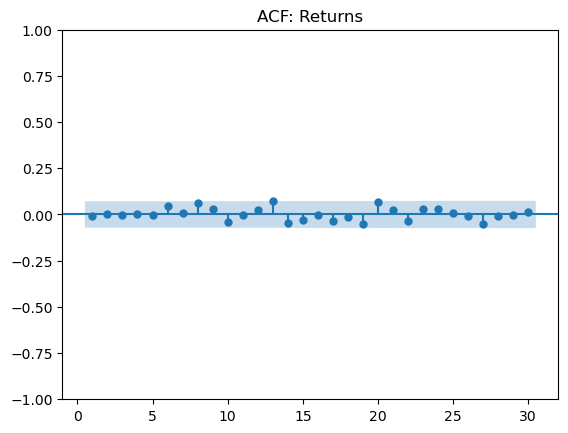

In [38]:
# ACF for returns

plt.figure(figsize=(10,4))
plot_acf(log_returns, lags=30, zero=False)
plt.title("ACF: Returns")
plt.show()


<Figure size 1000x400 with 0 Axes>

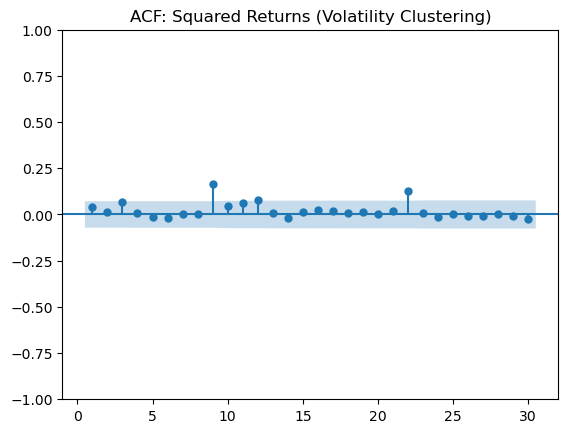

In [39]:
# ACF for squared returns

plt.figure(figsize=(10,4))
plot_acf(sq, lags=30, zero=False)
plt.title("ACF: Squared Returns (Volatility Clustering)")
plt.show()


<Figure size 1000x400 with 0 Axes>

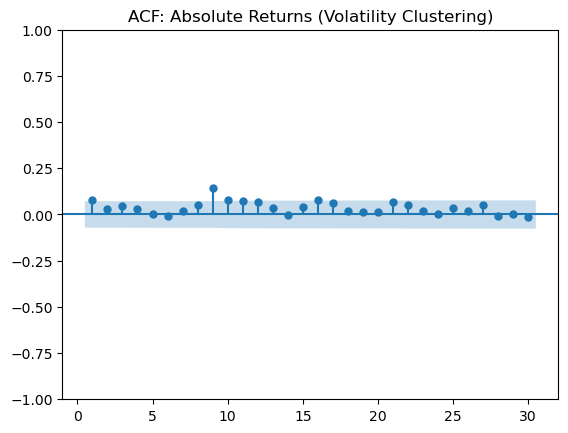

In [41]:
# ACF for absolute returns

plt.figure(figsize=(10,4))
plot_acf(ab, lags=30, zero=False)
plt.title("ACF: Absolute Returns (Volatility Clustering)")
plt.show()


In [42]:
# Ljung–Box test

lb_returns = acorr_ljungbox(log_returns.dropna(), lags=[5, 10, 20], return_df=True)
lb_returns


,lb_stat,lb_pvalue
5,0.075984,0.999918
10,6.772121,0.746769
20,19.827099,0.468791


In [43]:
# Squared returns: often shows strong evidence of clustering

lb_sq = acorr_ljungbox((log_returns.dropna()**2), lags=[5, 10, 20], return_df=True)
lb_sq

,lb_stat,lb_pvalue
5,4.971932,0.419315
10,28.128315,0.001722
20,37.354163,0.010608


Interpretation:

- p-value < 0.05 → reject “no autocorrelation” (there is memory)
- p-value > 0.05 → can’t reject (looks random at those lags)

### GARCH

In [44]:
# Important practical detail: many implementations expect returns in percent (not decimals). So we’ll use log_returns * 100.

r = (log_returns.dropna() * 100)

garch11 = arch_model(r, mean="Constant", vol="GARCH", p=1, q=1, dist="normal")
res = garch11.fit(disp="off")

print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   TSLA   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2047.67
Distribution:                  Normal   AIC:                           4103.34
Method:            Maximum Likelihood   BIC:                           4121.83
                                        No. Observations:                  751
Date:                Thu, Feb 19 2026   Df Residuals:                      750
Time:                        01:06:24   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1767      0.137      1.287      0.198 [-9.23

In [45]:
# Extract and interpret ω, α, β and α+β

params = res.params
omega = params.get("omega")
alpha = params.get("alpha[1]")
beta  = params.get("beta[1]")

print("omega:", omega)
print("alpha:", alpha, "  (shock sensitivity)")
print("beta :", beta,  "  (vol persistence)")
print("alpha + beta:", alpha + beta)


omega: 0.2233530947183316
alpha: 0.018299282752117365   (shock sensitivity)
beta : 0.9649301761180061   (vol persistence)
alpha + beta: 0.9832294588701235


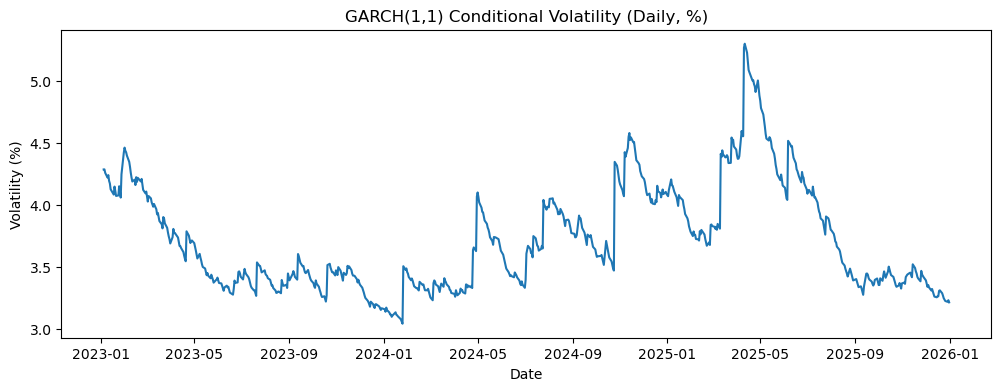

In [46]:
# Plot conditional volatility (the GARCH volatility “memory”)

cond_vol = res.conditional_volatility  # in percent units (because r is percent)

plt.figure(figsize=(12,4))
plt.plot(cond_vol)
plt.title("GARCH(1,1) Conditional Volatility (Daily, %)")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.show()


In [47]:
# Forecast volatility (next 5 days)

horizon = 5
forecasts = res.forecast(horizon=horizon)

# forecasted variance for the last available date, horizons 1..horizon
var_fc = forecasts.variance.iloc[-1]
vol_fc = np.sqrt(var_fc)

print("Forecasted daily volatility (%):")
print(vol_fc)


Forecasted daily volatility (%):
h.1    3.198536
h.2    3.206620
h.3    3.214549
h.4    3.222326
h.5    3.229954
Name: 2025-12-31 00:00:00, dtype: float64


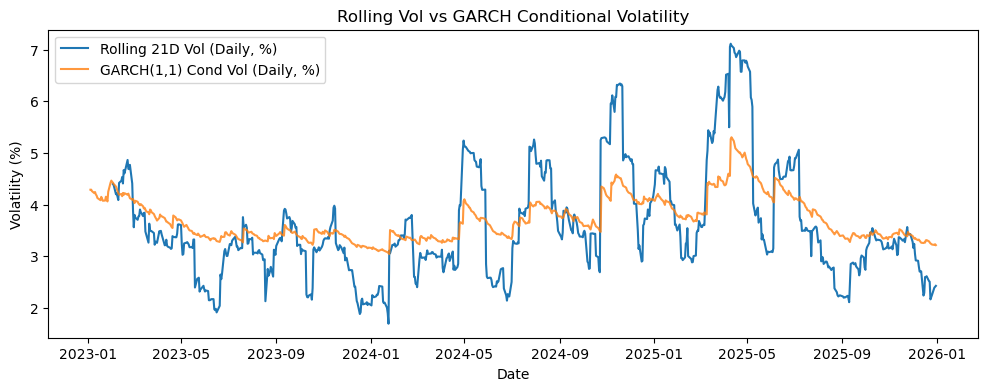

In [48]:
# Compare rolling volatility vs GARCH volatility

rolling_vol = (log_returns.rolling(21).std() * 100)  # daily rolling vol in %

# Plot both

plt.figure(figsize=(12,4))
plt.plot(rolling_vol, label="Rolling 21D Vol (Daily, %)")
plt.plot(cond_vol, label="GARCH(1,1) Cond Vol (Daily, %)", alpha=0.8)
plt.title("Rolling Vol vs GARCH Conditional Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility (%)")
plt.legend()
plt.show()
